# Prepares

In [1]:
#Load-in required packages and data
import os
os.chdir("E:/Projects/prediction")
import numpy as np
import pandas as pd
import random
import pycaret
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import roc_curve
data = pd.read_csv("data_elasticnet.txt",sep = "\t")

In [2]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,precision_score,recall_score

def stat_table(y_true,y_pred,pos_label):
    Accu = accuracy_score(y_true, y_pred)
    Recall = recall_score(y_true, y_pred, pos_label = pos_label)
    Prec = precision_score(y_true, y_pred, pos_label = pos_label)
    result = pd.DataFrame({'Accuracy':[Accu],'Recall':[Recall],'Precision':[Prec]})
    return result

### 绘制 micro-roc 曲线
def acu_curve(y_test,prob,classes):
    y = label_binarize(y_test, classes=classes)
    y = np.hstack((1-y,y))
    fpr,tpr,threshold = roc_curve(y.ravel(),prob.ravel()) ###计算真正率和假正率
    a = np.transpose([tpr,fpr])
    ap = pd.DataFrame(a)
    ap.columns = ['TPR','FPR']
    ap.to_csv('Reg_'+classes[1]+'.csv',index=False)
    
    roc_auc = auc(fpr,tpr) ###计算auc的值
 
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='lightcoral',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='mediumaquamarine', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig('Reg_'+classes[1]+'.pdf')
 
    plt.show()

In [3]:
### train-test sample splitting
data_class = data.drop(axis = 1,columns = ['SampleID'])
data_class['FEV1_rate'] = 1/data_class['FEV1_rate']
X_train,X_test,y_train,y_test = train_test_split(data_class.drop(axis = 1,columns = ['FEV1_rate']),
                                                 data_class['FEV1_rate'],test_size = 0.3,random_state = 0)

In [4]:
data_train = pd.concat([X_train,y_train],axis=1)
data_test = pd.concat([X_test,y_test],axis=1)

# Regression

In [5]:
### 先用training set对FEV1_rate做regression，再对test set的FEV1_rate做预测，将预测值作为一个新的变量代入回归
from pycaret.regression import *
### setup: 设置环境并进行数据预处理
### remove_multicollinearity：去除多重共线性，阈值设置为0.7
### session_id：random seed for reproducibility
### transformation: 对变量进行yeo-johnson变换
### ignor_features: 回归过程中忽略的变量
### silent: 是否输出数据预处理过程
setup(data_train, target = 'FEV1_rate',remove_multicollinearity = True, multicollinearity_threshold = 0.7,
    transformation = True,session_id = 42,ignore_features = ['Group'],silent = True)
### compare_models: 模型对比，依据R2排序
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,1077.1591,56627212.4740,2808.6984,-0.3071,1.7237,1.2850,0.0570
knn,K Neighbors Regressor,1156.9575,56160385.1602,2898.2909,-1.4809,1.6021,2.1446,0.0110
par,Passive Aggressive Regressor,1226.8139,56983234.5656,2957.1168,-2.5478,1.5833,3.1756,0.0100
dt,Decision Tree Regressor,1241.2361,56553290.4483,3048.1639,-7.1085,1.5003,2.6988,0.0100
rf,Random Forest Regressor,1501.5618,61209758.6954,3795.1640,-54.8934,1.8616,5.0684,0.1950
et,Extra Trees Regressor,1697.4367,60613942.1611,3973.5552,-59.1200,1.9914,7.4446,0.1400
lightgbm,Light Gradient Boosting Machine,2516.7582,61546121.5232,4443.2221,-59.9293,2.4243,16.3397,0.2370
gbr,Gradient Boosting Regressor,1497.3875,63239781.9536,3901.4343,-77.8213,1.7403,5.1268,0.0710
en,Elastic Net,3690.5926,70504846.5000,5918.9329,-252.4161,2.8393,29.1363,0.0080
omp,Orthogonal Matching Pursuit,4233.8874,76069638.2055,6596.8317,-325.0445,3.0510,33.3031,0.0080


AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=42)

In [6]:
ada_reg = create_model('ada') ### 创建模型
ada_reg_final = finalize_model(ada_reg) ### 使用training set所有的数据进行模型训练
tuned_ada = tune_model(ada_reg_final) ### 模型调参
pred_ada = predict_model(tuned_ada,data = data_test)['Label'] ### 对test set的FEV1_rate做预测
pred_ada_train = predict_model(tuned_ada,data = data_train)['Label'] ### training set的FEV1_rate拟合值
data_test['FEV1_rate'] = pred_ada
data_train['FEV1_rate'] = pred_ada_train

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,221.6513,157554.3600,396.9312,-0.0418,1.6218,0.7568
1,253.1281,102398.0340,319.9969,-0.2132,1.4717,0.7309
2,8047.3112,558704268.1393,23636.9259,-0.1231,2.5102,0.7824
3,230.0564,91245.3678,302.0685,0.0319,1.0584,1.6351
4,298.0750,104779.9373,323.6973,-0.0791,1.0962,1.2948
5,228.8218,201764.8268,449.1824,-0.1071,0.8895,1.0480
6,716.7368,2963696.9391,1721.5391,-0.0672,1.5589,1.4395
7,213.2281,96888.0158,311.2684,-0.0436,1.1267,1.1928
8,96.7829,16399.1537,128.0592,0.0526,0.7708,0.6917
9,230.6695,66609.6164,258.0884,-0.1557,1.2433,1.0279


# Classification

## RD vs NonRD

In [7]:
from pycaret.classification import *
data_RD_train = data_train.replace(["Slow_decliner","Sustainer"],"NonRD")
data_RD_test = data_test.replace(["Slow_decliner","Sustainer"],"NonRD")
RD_group = setup(data_RD_train,target = "Group", session_id = 43,silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6819,0.5938,0.2667,0.4917,0.3286,0.1448,0.1636,0.0180
ridge,Ridge Classifier,0.6819,0.0000,0.3333,0.2467,0.2710,0.1292,0.1422,0.0100
gbc,Gradient Boosting Classifier,0.6736,0.5988,0.2500,0.2567,0.2300,0.0853,0.0920,0.1490
et,Extra Trees Classifier,0.6625,0.6587,0.0833,0.1333,0.1000,-0.0148,-0.0223,0.1320
lr,Logistic Regression,0.6611,0.5806,0.3167,0.2500,0.2738,0.0981,0.1002,0.0510
rf,Random Forest Classifier,0.6611,0.5893,0.0000,0.0000,0.0000,-0.0711,-0.0756,0.1670
xgboost,Extreme Gradient Boosting,0.6500,0.4762,0.2500,0.3333,0.2567,0.0571,0.0656,0.1400
ada,Ada Boost Classifier,0.6486,0.5317,0.3333,0.2233,0.2543,0.0863,0.1014,0.0800
lightgbm,Light Gradient Boosting Machine,0.6250,0.4484,0.1833,0.2167,0.1967,-0.0150,-0.0165,0.0530
dt,Decision Tree Classifier,0.5792,0.4786,0.2333,0.2167,0.2152,-0.0492,-0.0533,0.0140


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7778,0.7143,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7778,0.8571,0.5000,0.5000,0.5000,0.3571,0.3571
2,0.6667,0.3889,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.6667,0.1111,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.6667,0.6111,0.3333,0.5000,0.4000,0.1818,0.1890
5,0.6667,0.8889,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.7778,0.7778,0.3333,1.0000,0.5000,0.4000,0.5000
7,0.5556,0.3889,0.0000,0.0000,0.0000,-0.2000,-0.2500
8,0.7500,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.7500,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000


<Figure size 432x288 with 0 Axes>

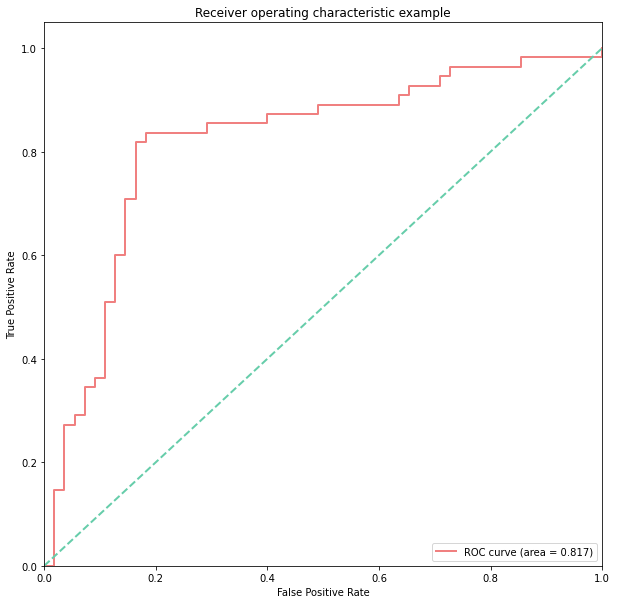

,Accuracy,Recall,Precision
0,0.818182,0.25,0.75


In [8]:
knn_RD = create_model('knn')
et_RD = create_model('et')
nb_RD = create_model('nb')
knn_RD_final = finalize_model(knn_RD)
et_RD_final = finalize_model(et_RD)
nb_RD_final = finalize_model(nb_RD)
blend_RD = blend_models(estimator_list = [knn_RD_final,et_RD_final,tune_model(nb_RD_final)],method = 'soft')
RD_pred = predict_model(blend_RD,data = data_RD_test)
method_RD = getattr(blend_RD,"predict_proba") ### 获得预测概率，以进行roc曲线的绘制
prob_RD = method_RD(data_RD_test[get_config('X_train').columns])
ROC_RD = acu_curve(data_RD_test['Group'],prob_RD,["NonRD", "Rapid_decliner"])
stat_table(data_RD_test['Group'],predict_model(blend_RD,data = data_RD_test)['Label'],pos_label = 'Rapid_decliner')

## SD vs NonSD

In [9]:
data_SD_train = data_train.replace(["Rapid_decliner","Sustainer"],"NonSD")
data_SD_test = data_test.replace(["Rapid_decliner","Sustainer"],"NonSD")
RD_group = setup(data_SD_train,target = "Group", session_id = 44,silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6319,0.6938,0.5500,0.6171,0.5508,0.2549,0.2737,0.1570
lda,Linear Discriminant Analysis,0.6139,0.6750,0.6300,0.6138,0.5918,0.2269,0.2602,0.0130
lightgbm,Light Gradient Boosting Machine,0.6139,0.6425,0.5300,0.5583,0.5255,0.2146,0.2210,0.0410
xgboost,Extreme Gradient Boosting,0.6097,0.6912,0.5300,0.5205,0.5092,0.2071,0.2069,0.1400
knn,K Neighbors Classifier,0.5778,0.5981,0.5350,0.5900,0.5285,0.1583,0.1852,0.0180
ada,Ada Boost Classifier,0.5583,0.5037,0.5100,0.5512,0.5098,0.1137,0.1227,0.1050
dt,Decision Tree Classifier,0.5556,0.5450,0.4300,0.4444,0.4200,0.0923,0.0829,0.0110
lr,Logistic Regression,0.5458,0.5925,0.5500,0.5310,0.5176,0.0872,0.0979,0.0540
et,Extra Trees Classifier,0.5458,0.4662,0.4550,0.5467,0.4663,0.0857,0.0963,0.1410
ridge,Ridge Classifier,0.5444,0.0000,0.6000,0.5362,0.5550,0.0980,0.0971,0.0090


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=44, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6667,0.6500,0.5000,0.6667,0.5714,0.3077,0.3162
1,0.6667,0.8000,0.5000,0.6667,0.5714,0.3077,0.3162
2,0.6667,0.7000,0.5000,0.6667,0.5714,0.3077,0.3162
3,0.4444,0.7500,1.0000,0.4444,0.6154,0.0000,0.0000
4,0.4444,0.6000,0.2500,0.3333,0.2857,-0.1538,-0.1581
5,0.4444,0.4500,0.2500,0.3333,0.2857,-0.1538,-0.1581
6,0.5556,0.7000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7778,1.0000,1.0000,0.7143,0.8333,0.5263,0.5976
8,0.2500,0.2500,0.0000,0.0000,0.0000,-0.5000,-0.5774
9,0.6250,0.6250,0.5000,0.6667,0.5714,0.2500,0.2582


<Figure size 432x288 with 0 Axes>

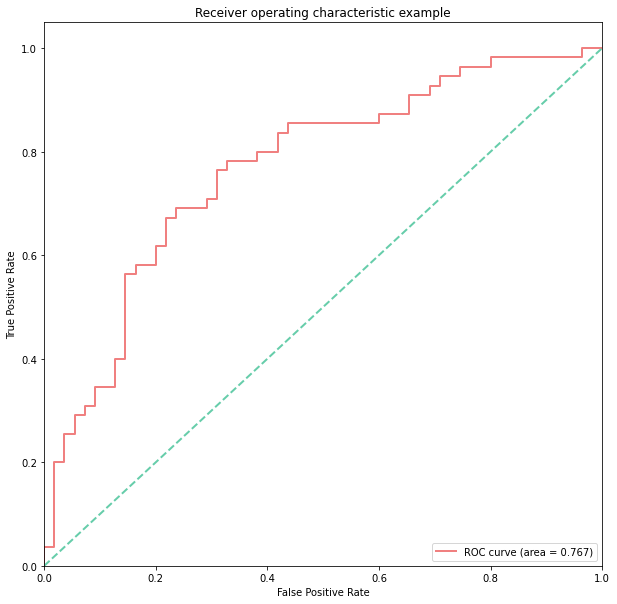

,Accuracy,Recall,Precision
0,0.709091,0.56,0.736842


In [10]:
dt_SD = create_model('dt')
gbc_SD = create_model('gbc')
lda_SD = create_model('lda')
dt_SD_final = finalize_model(dt_SD)
gbc_SD_final = finalize_model(gbc_SD)
lda_SD_final = finalize_model(lda_SD)
blend_SD = blend_models(estimator_list = [dt_SD_final,gbc_SD_final,tune_model(lda_SD_final)],method = 'soft')
method_SD = getattr(blend_SD,"predict_proba")
prob_SD = method_SD(data_SD_test[get_config('X_train').columns])
ROC_SD = acu_curve(data_SD_test['Group'],prob_SD,['NonSD','Slow_decliner'])
stat_table(data_SD_test['Group'],predict_model(blend_SD,data = data_SD_test)['Label'],pos_label = 'Slow_decliner')

## ST vs NonST

In [11]:
data_ST_train = data_train.replace(["Rapid_decliner","Slow_decliner"],"NonST")
data_ST_test = data_test.replace(["Rapid_decliner","Slow_decliner"],"NonST")
RD_group = setup(data_ST_train,target = "Group", session_id = 45,silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7514,0.5028,0.1333,0.3000,0.1833,0.1409,0.1566,0.0230
svm,SVM - Linear Kernel,0.7514,0.0000,0.1000,0.2000,0.1333,0.1209,0.1316,0.0100
lr,Logistic Regression,0.7403,0.6615,0.4500,0.5417,0.4586,0.3167,0.3359,0.0480
rf,Random Forest Classifier,0.7056,0.4060,0.0000,0.0000,0.0000,-0.0374,-0.0439,0.1650
ridge,Ridge Classifier,0.6556,0.0000,0.4000,0.2167,0.2800,0.1173,0.1330,0.0090
gbc,Gradient Boosting Classifier,0.6389,0.5040,0.1833,0.1833,0.1833,0.0097,0.0018,0.1610
xgboost,Extreme Gradient Boosting,0.6389,0.4738,0.1500,0.1250,0.1333,-0.0306,-0.0413,0.1610
nb,Naive Bayes,0.6375,0.6083,0.5500,0.4217,0.4295,0.1857,0.2265,0.0100
et,Extra Trees Classifier,0.6361,0.4607,0.0000,0.0000,0.0000,-0.1305,-0.1405,0.1400
ada,Ada Boost Classifier,0.6264,0.5944,0.2333,0.2833,0.2533,0.0155,0.0086,0.0840


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7778,0.7143,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.5556,0.5000,0.0000,0.0000,0.0000,-0.2857,-0.2857
2,0.7778,0.5714,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.6667,0.5000,0.0000,0.0000,0.0000,-0.1739,-0.1890
4,0.4444,0.2778,0.0000,0.0000,0.0000,-0.3636,-0.3780
5,0.6667,0.0556,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.6667,0.5556,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.6667,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.6250,0.8333,0.0000,0.0000,0.0000,-0.2000,-0.2182
9,0.7500,0.1667,0.0000,0.0000,0.0000,0.0000,0.0000


<Figure size 432x288 with 0 Axes>

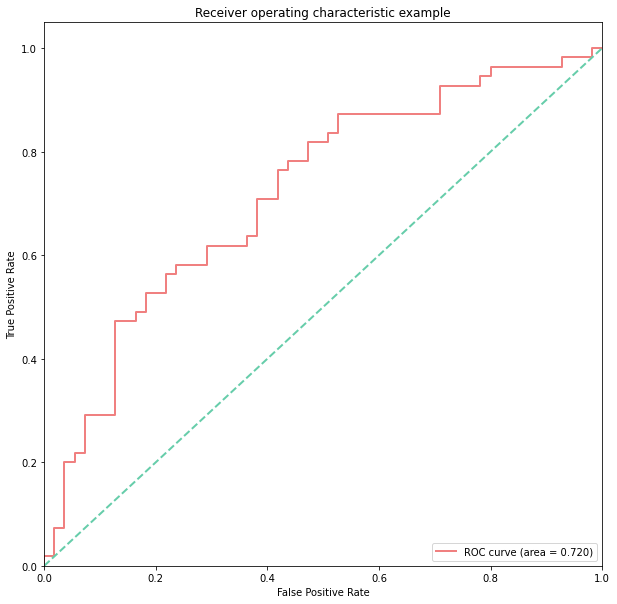

,Accuracy,Recall,Precision
0,0.636364,0.055556,0.25


In [12]:
knn_ST = create_model('knn')
knn_ST_final = finalize_model(knn_ST)
xgboost_ST = create_model('xgboost')
xgboost_ST_final = finalize_model(xgboost_ST)
lightgbm_ST = create_model('lightgbm')
lightgbm_ST_final = finalize_model(lightgbm_ST)
blend_ST = blend_models(estimator_list = [knn_ST_final,xgboost_ST_final,lightgbm_ST_final],method = 'soft')
method_ST = getattr(blend_ST,"predict_proba")
prob_ST = method_ST(data_ST_test[get_config('X_train').columns])
ROC_ST = acu_curve(data_ST_test['Group'],prob_ST,['NonST','Sustainer'])
stat_table(data_ST_test['Group'],predict_model(blend_ST,data = data_ST_test)['Label'],pos_label = 'Sustainer')